Title: Les séries temporelles avec Python (5/4) - Approche ML/DL
Author: Louis
Date: '2023-05-10'
Slug: timeseries-5
Category: Python
Tags: Python, Machine Learning, Statistiques, Data Science, Séries temporelles, Datetime
Cover: images/cover_6.png
Summary: Prédiction d'une série temporelle avec une approche de Machine Leraning/Deep Learning.

[TOC]

>1. Introduction à la manipulation de données temporelles avec Python
>2. Visualisation et opérations sur les séries temporelles
>3. Éléments théoriques et exemples
>4. Analyse, modélisation et prédiction
>5. **BONUS GRATOS : approche ML/DL**

On a vu jusqu'ici des modèles "classiques" de séries temporelles mais on peut aussi utiliser des modèles moins complexes tels qu'une simple régression linéaire ou un arbre de régression. En revanche pour cette approche il faut travailler un peu sur le format des données. Alors en route !

## **1. Import et preprocessing des données**

1. Récupérer les données de Google sur Yahoo!Finance (c'est la colonne "close" qui nous intéressera). Prendre tout l'historique (depuis le 19 août 2004)
2. Pour vous rafraîchir un peu la mémoire :
>- les charger en un objet série temporelle avec pandas,
>- modifier la fréquence pour être en "jours ouvrables"
>- afficher la série
3. Créer vos échantillons d'entraînement et de test en précisant la stratégie utilisée
4. Scaler vos données. C'est pas toujours nécessaires mais sans entrer dans des considérations trop matheuses, il vaut mieux le faire (généralement une normalisation min-max ou un standard scaler selon les modèles)
5. Transformer vos données de sorte qu'elles puissent servir pour entraîner un modèle ML, c'est-à-dire qu'on veut une matrice X d'inputs et un vecteur y de targets. Pour ça, vous devez vous demander, qu'est-ce que je veux prédire et avec quoi ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

plt.rcParams["figure.figsize"] = (18,8)

In [2]:
# Chargement des données sous forme de série temp
df = pd.read_csv('data/GOOG.csv', usecols=['Date','Close'], index_col='Date', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4636 entries, 2004-08-19 to 2023-01-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4636 non-null   float64
dtypes: float64(1)
memory usage: 72.4 KB


In [3]:
# Changement de la fréquence pour avoir une fréquence de "jours ouvrables"
df = df.asfreq('B', method="ffill")
df.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10',
               '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-16',
               '2023-01-17', '2023-01-18'],
              dtype='datetime64[ns]', name='Date', length=4805, freq='B')

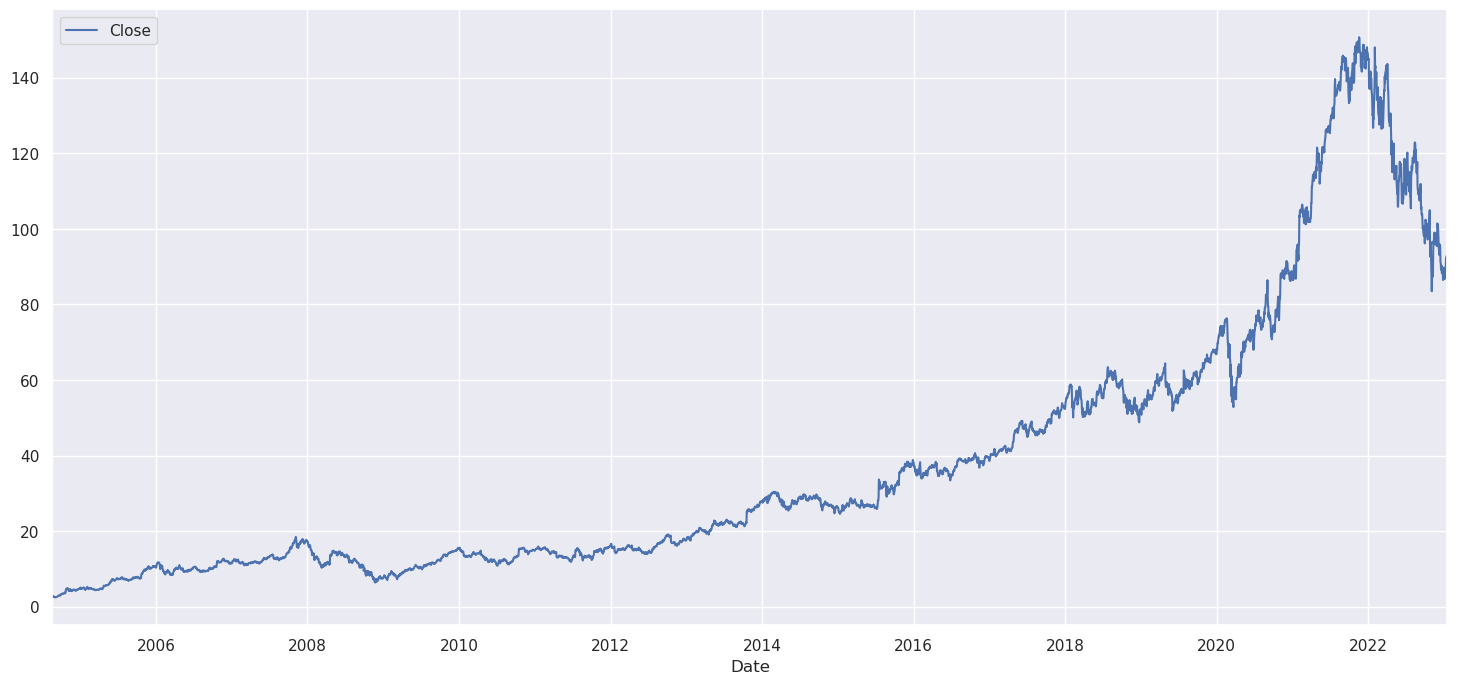

In [4]:
# affichage
df.plot();

In [5]:
# Création de la structure des données avec un nombre fixé n de timesteps (de jours) et 1 output
# c'est à dire qu'on va prédire la valeur de l'action pour 1 jour à partir des n jours précédents
timesteps = 40 #on crée un paramètre pour pouvoir le modifier facilement par la suite
X = []
y = []

for i in range(timesteps, df.shape[0]):
    X.append(df.iloc[i-timesteps:i, 0])
    y.append(df.iloc[i, 0])

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(4765, 40) (4765,)


In [11]:
X[:4,:], y[:4]

(array([[2.499133, 2.697639, 2.724787, 2.61196 , 2.640104, 2.687676,
         2.64384 , 2.540727, 2.549693, 2.496891, 2.528273, 2.490913,
         2.490913, 2.530017, 2.54795 , 2.548199, 2.623417, 2.677464,
         2.776842, 2.789544, 2.83861 , 2.926282, 2.972857, 2.934999,
         2.948448, 3.009221, 2.984563, 2.94546 , 3.159657, 3.264763,
         3.227901, 3.302123, 3.363891, 3.446332, 3.414203, 3.458287,
         3.430392, 3.368873, 3.422173, 3.509346],
        [2.697639, 2.724787, 2.61196 , 2.640104, 2.687676, 2.64384 ,
         2.540727, 2.549693, 2.496891, 2.528273, 2.490913, 2.490913,
         2.530017, 2.54795 , 2.548199, 2.623417, 2.677464, 2.776842,
         2.789544, 2.83861 , 2.926282, 2.972857, 2.934999, 2.948448,
         3.009221, 2.984563, 2.94546 , 3.159657, 3.264763, 3.227901,
         3.302123, 3.363891, 3.446332, 3.414203, 3.458287, 3.430392,
         3.368873, 3.422173, 3.509346, 3.536743],
        [2.724787, 2.61196 , 2.640104, 2.687676, 2.64384 , 2.540727,
   

In [13]:
# Train test split
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Feature-scaling : normalisation min-max
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

(3812, 40) (3812,) (953, 40) (953,)


## **2. Une régression linéaire simple**

1. Entraîner une régression linéaire. Mesurer et stocker la durée d'entraînement dans le dataframe `comparison` ci-dessous. 
2. Faire les prédictions sur l'échantillon test en mesurant et stockant la vitesse de prédiction dans`comparison`.
3. Mesurer les erreurs de prédiction avec les métriques listées dans `comparison` et les stocker également.
4. Visualiser les prédictions de votre modèle

```python
comparison = pd.DataFrame(
    index = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Other model', 'And another model'],
    columns=['Training time', 'Prediction time', 'RMSE', 'nRMSE', 'MAE', 'nMAE']
)
```

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9992318255473517

## **3. Comparaison de différents modèles**

1. Répéter les questions 2.1, 2.2 et 2.3 pour remplir le dataframe `comparison` avec différents modèles : un arbre de régression et une forêt aléatoire, un GradientBoosting (et éventuellement un ExtremeGradientBoosting). Si vous le sentez vous pouvez aussi ajouter un SARIMA.
2. Visualiser les prédictions de tous ces modèles sur un même graphique